In [113]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [114]:
df_btc = pd.read_csv("BTC_1h_data.csv")

In [115]:
df_btc

,date,open,high,low,close,volume
0,2017-08-17 04:00:00.000,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00.000,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00.000,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00.000,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00.000,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...
39216,2022-02-11 10:00:00,43492.63,43569.67,43233.67,43443.77,1305.626920
39217,2022-02-11 11:00:00,43443.78,43523.42,43320.00,43357.53,744.524180
39218,2022-02-11 12:00:00,43357.53,43700.78,43253.31,43570.77,1317.546940
39219,2022-02-11 13:00:00,43570.77,43826.00,43503.01,43765.14,1564.251800


In [116]:
df_headers = df_btc.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [117]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)

btc_data[-1]

43534.54

<Strong> Scaling the data  </Strong>

In [118]:
percTrain = 70
percVal = 20 

In [119]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [120]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [121]:
# Using 24 datapoints to predict the 25th

window_length = 24
features = 1

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [122]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [123]:
#Reshaping the data so we can use min-max a
btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

print(btc_train[0].shape)

(27370, 24, 1)


In [124]:
btc_test[1].shape

(4007, 1)

<Strong> Creating the model From the parameters found in the tuner. </Strong>

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_32 (LSTM)                 (None, 24, 30)       3840        ['input_17[0][0]']               
                                                                                                  
 dropout_25 (Dropout)           (None, 24, 30)       0           ['lstm_32[0][0]']                
                                                                                                  
 gru_14 (GRU)                   (None, 30)           2970        ['input_17[0][0]']               
                                                                                           

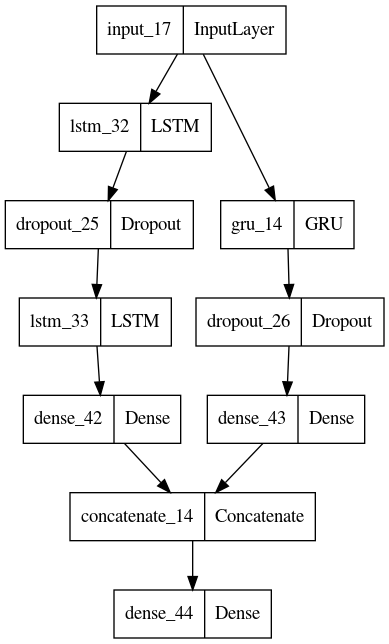

In [125]:
inputs = Input(shape = (window_length , features) )

x = LSTM(30 , return_sequences = True )(inputs)
x = Dropout(0.01)(x) 
x = LSTM(50)(x)
x = Dense(128)(x)

y = GRU(30,input_shape=(window_length , features))(inputs)
y = Dropout(0.01)(y)
y = Dense(128)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

model.summary()
plot_model(model)

<Strong> Creating a callback , so we can avail of early stopping </Strong>

In [ ]:
earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)

In [126]:
#Validation set needs to be in a tuple with x , y

model.compile(optimizer='adam' , loss = 'mse')

<Strong> Fitting the Model , and storing the epoch training stopped on </Strong>

In [128]:
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 5s 26ms/step - loss: 0.0101 - val_loss: 0.1142
Epoch 2/300
54/54 [==============================] - 0s 8ms/step - loss: 1.0655e-04 - val_loss: 0.1536
Epoch 3/300
54/54 [==============================] - 0s 8ms/step - loss: 8.2557e-05 - val_loss: 0.1479
Epoch 4/300
54/54 [==============================] - 0s 8ms/step - loss: 8.1591e-05 - val_loss: 0.1370
Epoch 5/300
54/54 [==============================] - 0s 8ms/step - loss: 8.0208e-05 - val_loss: 0.1297
Epoch 6/300
54/54 [==============================] - 0s 8ms/step - loss: 7.7927e-05 - val_loss: 0.1206
Epoch 7/300
54/54 [==============================] - 0s 8ms/step - loss: 7.6727e-05 - val_loss: 0.1160
Epoch 8/300
54/54 [==============================] - 0s 8ms/step - loss: 7.5482e-05 - val_loss: 0.1095
Epoch 9/300
54/54 [==============================] - 0s 8ms/step - loss: 7.3053e-05 - val_loss: 0.1045
Epoch 10/300
54/54 [==============================] - 0s 8ms/step - loss: 7.

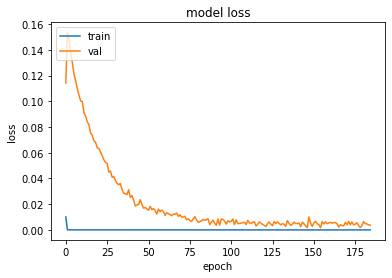

In [129]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.ylim([0,0.01])
plt.show()

<Strong> Testing our model on the validation data once again , hyper-parameter adjustment. <Strong>

In [130]:
validation_predict = model.predict(btc_val[0])
validation_predict = scaler.inverse_transform(validation_predict)

validation_actual = scaler.inverse_transform(btc_val[1])
mean_absolute_error(validation_actual , validation_predict)

713.8545868765985

<Strong> Combining the train and validation set when perfected hyper-parameters and training on fresh model. </Strong>

In [131]:
train_and_val = np.concatenate([btc_train[0] , btc_val[0]] )
train_and_val_targets = np.concatenate([btc_train[1] , btc_val[1] ])

freshModel = tf.keras.Model(inputs=inputs, outputs= final)

freshModel.compile(optimizer=opt , loss = 'mse')
final = freshModel.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs = num_epochs )

Epoch 1/184
69/69 [==============================] - 4s 8ms/step - loss: 1.1572
Epoch 2/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 3/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 4/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 5/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 6/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 7/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 8/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 9/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 10/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 11/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 12/184
69/69 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 13/184
69/69 [=================

<Strong> Finally testing on test set and grabbing evaluation metrics - 1 day </Strong>

In [132]:
test_predict = freshModel.predict(btc_test[0])
test_actual = btc_test[1]

In [133]:
print(mean_absolute_error(test_actual , test_predict))
print(mean_absolute_percentage_error(test_actual , test_predict))
print(mean_squared_error(test_actual , test_predict , squared = False))
print(mean_squared_error(test_actual , test_predict))

0.021389807028870993
0.0074093749416892915
0.028119833760028818
0.0007907250506916564


<Strong> For Predicting more than 1 day in the future - Test Set. </Strong>

In [134]:
def steps_in_future(hours_in_future , data):
    
    #All the hours_in_future time predictions
    predictions = []
    
    # Have to cut off the (hours_in_future - 1) off the test set to avoid out of bounds error
    test_data = data[0][:-(hours_in_future - 1)]
    
    for x in range (len(test_data)):
        #Going through all the windows
        last_window = test_data[x].reshape(1,-1)
    
            # Make as many predictions as hours_in_future
        for i in range(hours_in_future):
            
            # Take the predicted value from the last window in training set
            last_prediction = model.predict(last_window)[0]

            #shifting the window size one step down
            last_window[0] = np.roll(last_window[0], -1)

            #replacing the old value with new prediction
            last_window[0 , (len(last_window[0]) - 1)] = last_prediction

        #append prediction
        predictions.append(last_prediction)
    
    return predictions

In [ ]:
three_day_predictions = steps_in_future(3, btc_test)
five_day_predictions = steps_in_future(5, btc_test)
seven_day_predictions = steps_in_future( 7, btc_test)
nine_day_predictions = steps_in_future( 9, btc_test)
eleven_day_predictions = steps_in_future( 11, btc_test)

In [45]:
# Targets to compare  

targets_in_future_three = btc_test[1][(3 - 1):]
targets_in_future_five = btc_test[1][(5 - 1):]
targets_in_future_seven = btc_test[1][(7 - 1):]
targets_in_future_nine = btc_test[1][(9 - 1):]
targets_in_future_eleven = btc_test[1][(11 - 1):]

In [46]:
def get_eval_metrics(num_days , actual , results):
    
    mae = mean_absolute_error(actual , results)
    mse = mean_squared_error(actual , results )
    rmse = mean_squared_error(actual , results , squared = False)
    mape = mean_absolute_percentage_error(actual , results)

    print(num_days , "MAE :" , mae ,"MSE :" , mse , "RMSE :" , rmse , "MAPE :" , mape)

    return mae , mse , rmse , mape

In [48]:
three_days_mae , three_days_mse , three_days_rmse , three_days_mape = get_eval_metrics("Three Hour Forecast" , targets_in_future_three , three_day_predictions)
five_days_mae , five_days_mse , five_days_rmse , five_days_mape = get_eval_metrics("Five Hour Forecast" , targets_in_future_five , five_day_predictions)
seven_days_mae , seven_days_mse , seven_days_rmse , seven_days_mape = get_eval_metrics("Seven Hour Forecast" , targets_in_future_seven , seven_day_predictions)
nine_days_mae , nine_days_mse , nine_days_rmse , nine_days_mape = get_eval_metrics("Nine Hour Forecast" , targets_in_future_nine , nine_day_predictions)
eleven_days_mae , eleven_days_mse , eleven_days_rmse , eleven_days_mape = get_eval_metrics("Eleven Hour Forecast" , targets_in_future_eleven , eleven_day_predictions)




Three Hour Forecast MAE : 1937.2873043323616 MSE : 4845596.209604324 RMSE : 2201.2714983854953 MAPE : 0.03678470048901299
Five Hour Forecast MAE : 4371.369672436655 MSE : 22567175.544741116 RMSE : 4750.492137109703 MAPE : 0.08373141396933602
Seven Hour Forecast MAE : 7073.570467178011 MSE : 57344070.114500284 RMSE : 7572.586751863611 MAPE : 0.1360690818063687
Nine Hour Forecast MAE : 10019.666968514392 MSE : 112994088.44807273 RMSE : 10629.86775308483 MAPE : 0.19338272879582746
Eleven Hour Forecast MAE : 13036.373492802204 MSE : 188914633.26915896 RMSE : 13744.62197621888 MAPE : 0.25222003058676495
